In [ ]:
!pip install pytorch-msssim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from typing import List, Tuple, Dict
from pytorch_msssim import MS_SSIM
import math
import time
import h5py
import json
import os

# Configuración de dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR = '/content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley'
MODEL_PATH = f'{BASE_DIR}/Strohm_model.t7'
CHECKPOINT_FILENAME = 'tmab_shapley_checkpoint.json'

### UNet Parts

In [ ]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DoubleConvLeaky(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)



class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class DownLeaky(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvLeaky(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Up_v2(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, mid_channels):
        super().__init__()

        # # if bilinear, use the normal convolutions to reduce the number of channels
        # self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # self.conv = DoubleConv(in_channels, out_channels, mid_channels)

        self.up = nn.ConvTranspose2d(in_channels//2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, mid_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)

### UNet Architectures

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class UNet_Strohm2020(nn.Module):
    """
    This is a regular UNet where "two convolutional layers with strides 2 and 3 were added"
    """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_Strohm2020, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # self.downsampling = nn.Sequential(
        #     nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=(2,1), padding=1, bias=False),
        #     # nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=3, padding=1, bias=False),
        # )
        self.inc = DoubleConvLeaky(n_channels, 64)
        self.down1 = DownLeaky(64, 128)
        self.down2 = DownLeaky(128, 256)
        self.down3 = DownLeaky(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = DownLeaky(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        # self.upsample = nn.Upsample(size=(1600, 256), mode='bilinear', align_corners=True)

    def forward(self, x):
        # print(f"x: {x.size()}")
        # x0 = self.downsampling(x)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class Wang2020UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    # net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)

    # def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
    def __init__(self, input_nc, output_nc, num_downs=6, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(Wang2020UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class Wang2020UnetDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    # net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Wang2020UnetDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)



class UNet_nair2020(nn.Module):
    """
    A unet architecture with one encoder and 2 decoders
    Encoder: VGG13 like architecture
    """
    def __init__(self, n_channels, n_classes):
        # model input: torch.Size([1, 2, 800, 128])
        super(UNet_nair2020, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        self.up1d = Up_v2(1024, 256, mid_channels=256)
        self.up2d = Up_v2(512, 128, mid_channels=128)
        self.up3d = Up_v2(256, 64, mid_channels=64)
        self.up4d = Up_v2(128, 64, mid_channels=64)
        self.outcd = OutConv(64, n_classes)

        self.up1sp = Up_v2(1024, 256, mid_channels=256)
        self.up2sp = Up_v2(512, 128, mid_channels=128)
        self.up3sp = Up_v2(256, 64, mid_channels=64)
        self.up4sp = Up_v2(128, 64, mid_channels=64)
        self.outcsp = OutConv(64, n_classes)

    def forward(self, x):
        # model input: torch.Size([1, 2, 800, 128])
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        d = self.up1d(x5, x4)
        d = self.up2d(d, x3)
        d = self.up3d(d, x2)
        d = self.up4d(d, x1)
        logits_D = self.outcd(d)

        sp = self.up1sp(x5, x4)
        sp = self.up2sp(sp, x3)
        sp = self.up3sp(sp, x2)
        sp = self.up4sp(sp, x1)
        logits_Sp = self.outcsp(sp)

        return logits_D, logits_Sp

    # def calculate_receptive_field(self, input_size):
    #     rf = 1
    #     for module in self.modules():
    #         if isinstance(module, nn.Conv2d):
    #             rf += (module.kernel_size[0] - 1) * module.dilation[0]
    #             rf += (module.kernel_size[0] - 1) * module.dilation[0]
    #             rf -= module.padding[0]
    #     return rf

class UNet_nair2020_1deco(nn.Module):
    """
    A unet architecture with one encoder and 1 decoders
    Encoder: VGG13 like architecture
    """
    def __init__(self, n_channels, n_classes):
        super(UNet_nair2020_1deco, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        self.up1d = Up_v2(1024, 256, mid_channels=256)
        self.up2d = Up_v2(512, 128, mid_channels=128)
        self.up3d = Up_v2(256, 64, mid_channels=64)
        self.up4d = Up_v2(128, 64, mid_channels=64)
        self.outcd = OutConv(64, n_classes)

        self.up1sp = Up_v2(1024, 256, mid_channels=256)
        self.up2sp = Up_v2(512, 128, mid_channels=128)
        self.up3sp = Up_v2(256, 64, mid_channels=64)
        self.up4sp = Up_v2(128, 64, mid_channels=64)
        self.outcsp = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        d = self.up1d(x5, x4)
        d = self.up2d(d, x3)
        d = self.up3d(d, x2)
        d = self.up4d(d, x1)
        logits_D = self.outcd(d)

        return logits_D

### Show Dataset

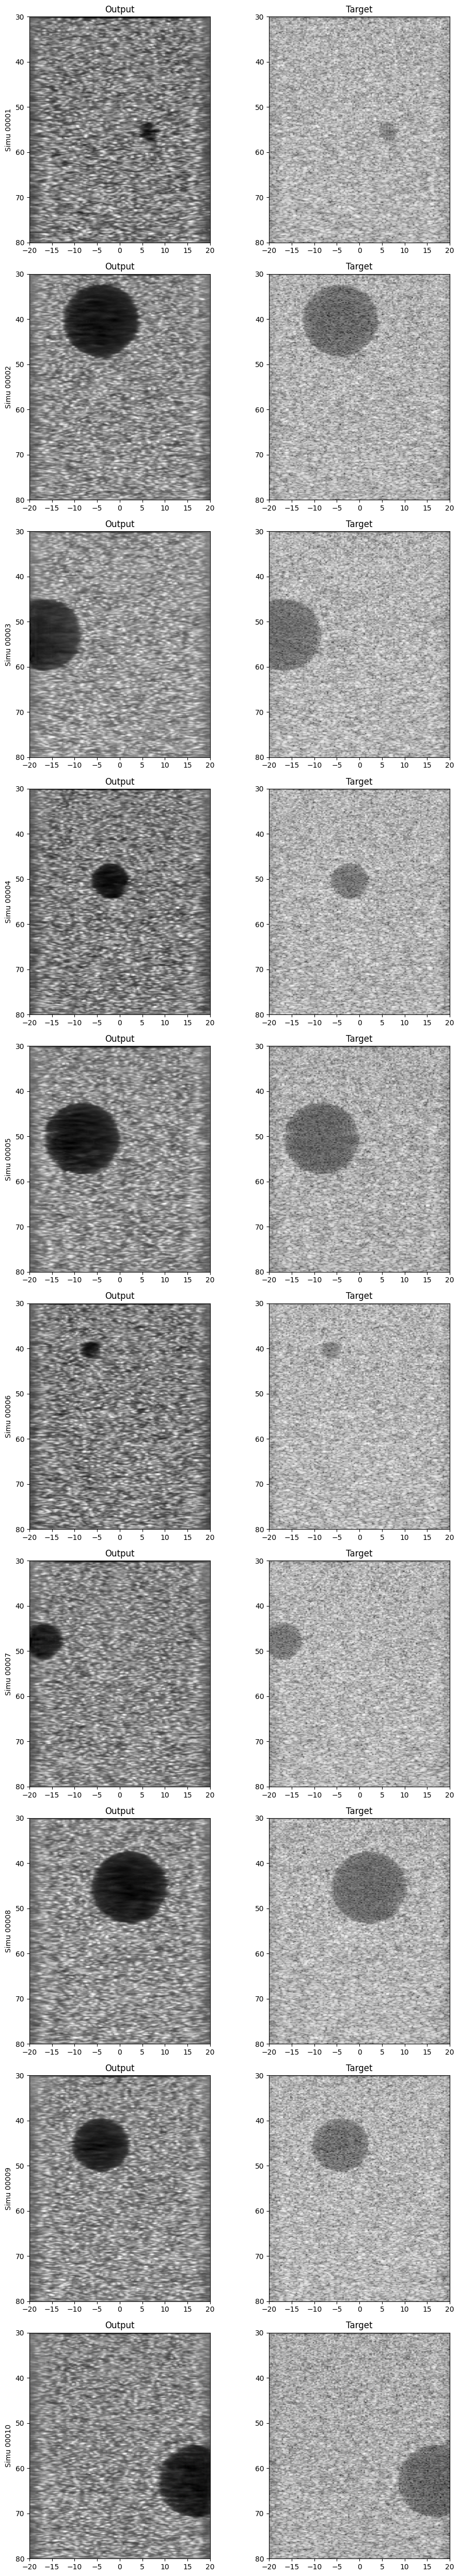

In [ ]:
# model = UNet(n_channels=2, n_classes=1).to(device)

#input = N_batchsxN_channelsxHxW
#input = 1x2x800x128

def process_and_plot(model, input_path, target_path, ax_output, ax_target, device):
    # Cargar y procesar la entrada
    sample = np.load(input_path)
    input_tensor = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # Obtener la salida del modelo
    with torch.no_grad():
        output = model(input_tensor)

    # Cargar el target
    target = np.load(target_path)

    # Configurar las opciones de visualización
    extent_full = [-20, 20, 80, 30]
    opts = {"extent": extent_full, "origin": "upper"}

    # Mostrar la salida del modelo
    ax_output.imshow(output.squeeze().cpu().numpy(), **opts, cmap='gray')
    ax_output.set_title('Output')

    # Mostrar el target
    ax_target.imshow(target, **opts, cmap='gray')
    ax_target.set_title('Target')

# Configurar el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo
model = UNet_Strohm2020(n_channels=2, n_classes=1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/Strohm_model.t7', map_location=device, weights_only=True))
model.eval()

# Crear el subplot
n_images = 10
fig, axes = plt.subplots(n_images, 2, figsize=(10, 5*n_images))

for i in range(n_images):
    input_path = f'/content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/input_id/simu{i+1:05d}.npy'
    target_path = f'/content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/target_from_raw/simu{i+1:05d}.npy'

    process_and_plot(model, input_path, target_path, axes[i, 0], axes[i, 1], device)
    axes[i, 0].set_ylabel(f'Simu {i+1:05d}')

plt.tight_layout()
plt.show()

### Shapley Utils

In [ ]:
def calculate_ssim(model: nn.Module, input_path: str, target_path: str) -> float:
    sample = np.load(input_path)
    input_tensor = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    output_np = output.squeeze().cpu().numpy()
    target_np = np.load(target_path)

    # Especificamos data_range basado en el rango de los datos
    data_range = max(np.max(output_np) - np.min(output_np), np.max(target_np) - np.min(target_np))

    return ssim(output_np, target_np, data_range=1.0)

#-----Multi-Scale Structural Similarity Index
def calculate_ms_ssim(model: nn.Module, input_path: str, target_path: str, ms_ssim_function) -> float:
    sample = np.load(input_path)
    input_tensor = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    # Cargar el target y convertirlo a tensor
    target_np = np.load(target_path)
    target_tensor = torch.from_numpy(target_np).unsqueeze(dim=0).unsqueeze(dim=0).to(device)

    # print('min target', target_tensor.min(), '\n')
    # print('max target', target_tensor.max(), '\n')
    # print('min output', output.min(), '\n')
    # print('max output', output.max(), '\n')

    ms_ssim_value = ms_ssim_function(output, target_tensor)

    return ms_ssim_value.cpu().item()

def remove_filters(model: nn.Module, filters: List[Tuple[str, int]]) -> None:
    for layer_name, filter_index in filters:
        parts = layer_name.split('.')
        module = model
        for part in parts[:-1]:
            if part.isdigit():
                module = module[int(part)]
            else:
                module = getattr(module, part)
        layer = getattr(module, parts[-1])
        if isinstance(layer, nn.Conv2d):
            layer.weight.data[int(filter_index)].fill_(0)
            if layer.bias is not None:
                layer.bias.data[int(filter_index)] = 0
        elif isinstance(layer, nn.BatchNorm2d):
            layer.weight.data[int(filter_index)] = 0
            layer.bias.data[int(filter_index)] = 0

def get_filters(model: nn.Module) -> List[Tuple[str, int]]:
    filters = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            filters.extend([(f"{name}.weight", i) for i in range(module.out_channels)])
        elif isinstance(module, nn.BatchNorm2d):
            filters.extend([(f"{name}.weight", i) for i in range(module.num_features)])
    return filters

### Checkpoints

In [ ]:
def save_checkpoint(state, filename=CHECKPOINT_FILENAME):
    checkpoint_path = os.path.join(os.path.dirname(MODEL_PATH), filename)
    with open(checkpoint_path, 'w') as f:
        json.dump(state, f, indent=4)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_checkpoint(filename=CHECKPOINT_FILENAME):
    checkpoint_path = os.path.join(os.path.dirname(MODEL_PATH), filename)
    with open(checkpoint_path, 'r') as f:
        state = json.load(f)
    print(f"Checkpoint loaded from {checkpoint_path}")
    return state

### Shapley Run

In [ ]:
def tmab_shapley(model: nn.Module,
                 num_filters: int,
                 num_samples: int,
                 truncation: float,
                 delta: float,
                 epsilon: float,
                 base_path: str,
                 ms_ssim_loss,
                 checkpoint_interval: int = 10,
                 resume_from_checkpoint: bool = False) -> Dict[Tuple[str, int], float]:

    if resume_from_checkpoint:
        state = load_checkpoint()
        filters = state['filters']
        values = {tuple(eval(k)): v for k, v in state['values'].items()}
        counts = {tuple(eval(k)): v for k, v in state['counts'].items()}
        variances = {tuple(eval(k)): v for k, v in state['variances'].items()}
        start_sample = state['current_sample']
        original_ssim = state['original_ssim']
    else:
        filters = get_filters(model)
        values = {tuple(filter): 0.0 for filter in filters}
        counts = {tuple(filter): 0 for filter in filters}
        variances = {tuple(filter): 0.0 for filter in filters}
        start_sample = 0
        original_ssim = np.mean([calculate_ms_ssim(model, f'{base_path}/input_id/simu{i:05d}.npy',
                                                f'{base_path}/target_from_raw/simu{i:05d}.npy', ms_ssim_loss)
                                 for i in range(1, 6)])

    print(f"Total number of filters: {len(filters)}")
    print("First 5 filters:", filters[:5])
    print("Last 5 filters:", filters[-5:])

    for sample in range(start_sample, num_samples):
        print(f"Sample {sample + 1}/{num_samples}")
        permutation = np.random.permutation(filters).tolist()
        model_copy = UNet_Strohm2020(n_channels=2, n_classes=1).to(device)
        model_copy.load_state_dict(model.state_dict())

        ssim_score = original_ssim
        for i, filter in enumerate(permutation):
            filter_tuple = filter
            filter_tuple[1] = int(filter_tuple[1])
            filter_tuple = tuple(filter_tuple)

            # print('is filter_tuple a tuple?: ', isinstance(filter_tuple, tuple))
            # print('is len(filter_tuple) == 2?: ', len(filter_tuple) == 2)
            # print('is filter_tuple[0] a str?: ', isinstance(filter_tuple[0], str))
            # print('is filter_tuple[1] an int?: ', isinstance(filter_tuple[1], int))

            if filter_tuple not in counts:
                print(f"Adding missing filter {filter_tuple} to dictionaries")
                counts[filter_tuple] = 0
                values[filter_tuple] = 0.0
                variances[filter_tuple] = 0.0

            if ssim_score < truncation * original_ssim:
                print(f"Truncated at filter {i}/{len(filters)}")
                break

            remove_filters(model_copy, [filter])
            new_ssim = np.mean([calculate_ms_ssim(model_copy, f'{base_path}/input_id/simu{i:05d}.npy',
                                               f'{base_path}/target_from_raw/simu{i:05d}.npy', ms_ssim_loss)
                                for i in range(1, 6)])
            marginal_contribution = ssim_score - new_ssim

            counts[filter_tuple] += 1
            old_avg = values[filter_tuple]
            values[filter_tuple] += (marginal_contribution - values[filter_tuple]) / counts[filter_tuple]
            variances[filter_tuple] += (marginal_contribution - old_avg) * (marginal_contribution - values[filter_tuple])

            ssim_score = new_ssim

        # Límites de confianza de Bernstein
        for filter in filters:
            filter_tuple = tuple(filter)
            if counts[filter_tuple] > 1:
                std_dev = math.sqrt(variances[filter_tuple] / (counts[filter_tuple] - 1))
                cb = math.sqrt(2 * math.log(2 / delta) / counts[filter_tuple]) * std_dev + \
                     7 * math.log(2 / delta) / (3 * (counts[filter_tuple] - 1))
                upper_bound = values[filter_tuple] + cb
                lower_bound = values[filter_tuple] - cb

                k_largest_value = sorted(values.values(), reverse=True)[min(num_filters - 1, len(values) - 1)]
                if lower_bound > k_largest_value + epsilon or upper_bound < k_largest_value - epsilon:
                    counts[filter_tuple] = float('inf')  # Marcar como inactivo para MAB

        active_filters = [f for f in filters if counts[tuple(f)] < float('inf')]
        print(f"Active filters: {len(active_filters)}")
        if len(active_filters) <= num_filters:
            print("Breaking early due to convergence")
            break

        if (sample + 1) % checkpoint_interval == 0:
                state = {
                    'filters': filters,
                    'values': {str(k): v for k, v in values.items()},
                    'counts': {str(k): v for k, v in counts.items()},
                    'variances': {str(k): v for k, v in variances.items()},
                    'current_sample': sample + 1,
                    'original_ssim': original_ssim
                }
                save_checkpoint(state)

    return {filter: value for filter, value in values.items()}

# Cargar el modelo
model = UNet_Strohm2020(n_channels=2, n_classes=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
model.eval()

# Configurar parámetros
num_filters = 1000 # 10 # Número de filtros más importantes a identificar
num_samples = 50 # 100 # Número de muestras para TMAB Shapley
truncation = 0.2  # Umbral de truncamiento
delta = 0.1  # Parámetro delta para los límites de confianza de Bernstein
epsilon = 0.01  # Parámetro epsilon para MAB
checkpoint_interval = 1 # Intervalo para guardar checkpoint
ms_ssim_loss = MS_SSIM(data_range=1.0, size_average=True, channel=1, win_size=7, K = (0.01, 0.03))

# Ejecutar TMAB Shapley
start_time = time.time()
# shapley_values = tmab_shapley(model, num_filters, num_samples, truncation, delta, epsilon, BASE_DIR, ms_ssim_loss, checkpoint_interval, resume_from_checkpoint=False)
# Para reanudar desde un checkpoint:
shapley_values = tmab_shapley(model, num_filters, num_samples, truncation, delta, epsilon, BASE_DIR, ms_ssim_loss, checkpoint_interval, resume_from_checkpoint=True)
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados
for filter, value in sorted(shapley_values.items(), key=lambda x: x[1], reverse=True)[:num_filters]:
    print(f"Filter {filter}: Shapley value = {value}")

print(f"Execution time: {execution_time:.2f} seconds")

# Guardar resultados en archivo .h5
with h5py.File('tmab_shapley_results.h5', 'w') as f:
    # Guardar valores de Shapley
    shapley_group = f.create_group('shapley_values')
    for filter, value in shapley_values.items():
        shapley_group.create_dataset(f"{filter[0]}_{filter[1]}", data=value)

    # Guardar tiempo de ejecución
    f.create_dataset('execution_time', data=execution_time)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.bar(range(len(shapley_values)), sorted(shapley_values.values(), reverse=True))
plt.title('Filter Importance (Shapley Values)')
plt.xlabel('Filter Rank')
plt.ylabel('Shapley Value')
plt.tight_layout()
plt.show()

print(f"Results saved to 'tmab_shapley_results.h5'")

Checkpoint loaded from /content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/tmab_shapley_checkpoint.json
Total number of filters: 8833
First 5 filters: [['inc.double_conv.0.weight', 0], ['inc.double_conv.0.weight', 1], ['inc.double_conv.0.weight', 2], ['inc.double_conv.0.weight', 3], ['inc.double_conv.0.weight', 4]]
Last 5 filters: [['up4.conv.double_conv.4.weight', 60], ['up4.conv.double_conv.4.weight', 61], ['up4.conv.double_conv.4.weight', 62], ['up4.conv.double_conv.4.weight', 63], ['outc.conv.0.weight', 0]]
Sample 22/50
Active filters: 8833
Checkpoint saved to /content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/tmab_shapley_checkpoint.json
Sample 23/50
Active filters: 8833
Checkpoint saved to /content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/tmab_shapley_checkpoint.json
Sample 24/50
Active filters: 8833
Checkpoint saved to /content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/tmab_shapley_checkpoint

In [ ]:
model = UNet_Strohm2020(n_channels=2, n_classes=1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DPB4 GradCAM/TMAB - Shapley/Pytorch/U-Net Shapley/Strohm_model.t7', map_location=device, weights_only=True))
model.eval()

UNet_Strohm2020(
  (inc): DoubleConvLeaky(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): DownLeaky(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvLeaky(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplac

In [ ]:
def get_filters(model: nn.Module) -> List[Tuple[str, int]]:
    filters = []
    for name, param in model.named_parameters():
        if 'weight' in name and len(param.shape) >= 2:  # Conv2d o Linear weights
            filters.extend([(name, i) for i in range(param.shape[0])])
        elif 'weight' in name and len(param.shape) == 1:  # BatchNorm2d weights
            filters.extend([(name, i) for i in range(param.shape[0])])
    return filters

# def get_filters(model: nn.Module) -> List[Tuple[str, int]]:
#     filters = []
#     for name, module in model.named_modules():
#         if isinstance(module, nn.Conv2d):
#             filters.extend([(f"{name}.weight", i) for i in range(module.out_channels)])
#         elif isinstance(module, nn.BatchNorm2d):
#             filters.extend([(f"{name}.weight", i) for i in range(module.num_features)])
#     return filters

def print_filters(filters: List[Tuple[str, int]]):
    print(f"Total number of filters: {len(filters)}")
    print("\nFirst 10 filters:")
    for f in filters[:10]:
        print(f)
    print("\nLast 10 filters:")
    for f in filters[-10:]:
        print(f)

    # Contar filtros por capa
    layer_counts = {}
    for name, _ in filters:
        layer_name = name.split('.')[0]
        if layer_name in layer_counts:
            layer_counts[layer_name] += 1
        else:
            layer_counts[layer_name] = 1

    print("\nFilter count by layer:")
    for layer, count in layer_counts.items():
        print(f"{layer}: {count}")

# Obtener los filtros
filters = get_filters(model)

# Imprimir información sobre los filtros
print_filters(filters)

Total number of filters: 8833

First 10 filters:
('inc.double_conv.0.weight', 0)
('inc.double_conv.0.weight', 1)
('inc.double_conv.0.weight', 2)
('inc.double_conv.0.weight', 3)
('inc.double_conv.0.weight', 4)
('inc.double_conv.0.weight', 5)
('inc.double_conv.0.weight', 6)
('inc.double_conv.0.weight', 7)
('inc.double_conv.0.weight', 8)
('inc.double_conv.0.weight', 9)

Last 10 filters:
('up4.conv.double_conv.4.weight', 55)
('up4.conv.double_conv.4.weight', 56)
('up4.conv.double_conv.4.weight', 57)
('up4.conv.double_conv.4.weight', 58)
('up4.conv.double_conv.4.weight', 59)
('up4.conv.double_conv.4.weight', 60)
('up4.conv.double_conv.4.weight', 61)
('up4.conv.double_conv.4.weight', 62)
('up4.conv.double_conv.4.weight', 63)
('outc.conv.0.weight', 0)

Filter count by layer:
inc: 256
down1: 512
down2: 1024
down3: 2048
down4: 2048
up1: 1536
up2: 768
up3: 384
up4: 256
outc: 1


AttributeError: 'generator' object has no attribute 'tolist'